### Anna Urbala
# Implementacja NEAT



NEAT zaimplementowany w tym tygodniu musi już działać poprawnie. Zaimplementować pozostałe elementy mutacji (dodawanie połączeń) i numery sekwencyjne elementów dodawanych przy mutacji (jeśli nie powstały wcześniej), operator krzyżowania.

Nauczyć tak zbudowaną sieć na zbiorach:
- rings3 (z laboratorium część o sieciach neuronowych)


W odpowiedzi na komentarz do poprzedniego zadania - kod to java przepisana na pythona (z drobnymi modyfikacjami) na podstawie tutoriala z prezentacji wykładowej, dlatego może być znajomy.

Link do tutoriala: [https://www.youtube.com/watch?v=1I1eG-WLLrY](https://www.youtube.com/watch?v=dQw4w9WgXcQ)

In [139]:
from enum import Enum, auto
import random
from copy import deepcopy
import math
import operator
import numpy as np


def sigmoid(x):
    #return 1 / (1 + math.exp(-x))
    return np.exp(x) / (1 + np.exp(x))

def relu(x):
    return max(x, 0)

def tanh(x):
    return math.tanh(x)

functions = [relu, tanh, sigmoid]

class NodeType(Enum):
    INPUT = auto()
    HIDDEN = auto()
    OUTPUT = auto()

class ConnectionGene:
    def __init__(self, inNode: int, outNode: int, weight=1.0, expressed=True, innovation=0):
        self.inNode = inNode
        self.outNode = outNode
        self.weight = weight
        self.expressed = expressed
        self.innovation = innovation
    
    def __repr__(self):
        return "ConnectionGene(%s - %s -> %s, inn: %s)" % (self.inNode, self.weight, self.outNode, self.innovation)
    
    def disable(self):
        self.expressed = False

class NodeGene:
    def __init__(self, type_: NodeType, id_: int, bias: float, fun):
        self.type = type_
        self.id = id_
        self.bias = bias
        self.fun = fun
    
    def __repr__(self):
        return "NodeGene_%s(inn: %s, bias: %s, fun: %s)" % (self.type, self.id, self.bias, self.fun)

class Counter:
    def __init__(self):
        self.innovation = 0
        
    def getInnovation(self):
        self.innovation += 1
        return self.innovation
    
class Genome:
    PROB_PERTURBING = 0.9
    PROB_BIAS_PERTURBING = 0.9
    
    def __init__(self):
        self.connections = {}
        self.nodes = {}
    
    def addNodeGene(self, gene: NodeGene):
        self.nodes[gene.id] = gene
    
    def addConnectionGene(self, gene: ConnectionGene):
        self.connections[gene.innovation] = gene
        
    def mutation(self):
        for conn in self.connections.values():
            if random.uniform(0, 1.0) < self.PROB_PERTURBING:
                conn.weight *= random.uniform(-2.0, 2.0)
            else:
                conn.weight = random.uniform(-2.0, 2.0)
    
    def biasMutation(self):
        for node in self.nodes.values():
            if random.uniform(0, 1.0) < self.PROB_BIAS_PERTURBING:
                node.bias *= random.uniform(-2.0, 2.0)
            else:
                node.bias = random.uniform(-2.0, 2.0)
    
    def activationMutation(self):
        for node in self.nodes.values():
            node.fun = random.choice(functions)
            
    
    def addConnectionMutation(self, innovation: Counter, maxAttempts):
        tries = 0
        success = False
        while tries < maxAttempts and success == False:
            tries += 1
            node1 = self.nodes[random.choice(list(self.nodes.keys()))]
            node2 = self.nodes[random.choice(list(self.nodes.keys()))]

            rev = False
            if node1.type.value > node2.type.value:
                rev = True
                node1,node2 = node2,node1
            
            connectionImpossible = False
            if (node1.type == NodeType.INPUT and node2.type == NodeType.INPUT) \
            or (node1.type == NodeType.OUTPUT and node2.type == NodeType.OUTPUT):
                connectionImpossible = True

            connectionExists = False
            for conn in self.connections.values():
                if (conn.inNode == node1.id and conn.outNode == node2.id) \
                or (conn.inNode == node2.id and conn.outNode == node1.id):
                    connectionExists = True
                    break
            
            if connectionExists or connectionImpossible:
                continue

            newConn = ConnectionGene(node1.id, node2.id, weight=random.uniform(-1.0, 1.0), innovation=innovation.getInnovation())
            self.addConnectionGene(newConn)
            success = True
    
    def addNodeMutation(self, connectionInnovation: Counter, nodeInnovation: Counter):
        conn = self.connections[random.choice(list(self.connections.keys()))]
        
        inNode = self.nodes[conn.inNode]
        outNode = self.nodes[conn.outNode]
        
        conn.disable()
        
        newNode = NodeGene(NodeType.HIDDEN, nodeInnovation.getInnovation(), random.uniform(-1, 1), random.choice(functions))
        newConn1 = ConnectionGene(inNode.id, newNode.id, innovation=connectionInnovation.getInnovation())
        newConn2 = ConnectionGene(newNode.id, outNode.id, weight=conn.weight, innovation=connectionInnovation.getInnovation())
        
        self.addNodeGene(newNode)
        self.addConnectionGene(newConn1)
        self.addConnectionGene(newConn2)
    
    
    @staticmethod
    def crossover(parent1, parent2):
        child = Genome()
        for parent1Node in parent1.nodes.values():
            child.addNodeGene(deepcopy(parent1Node))
            
        for parent2Node in parent2.nodes.values():
            if parent2Node.id not in parent1.nodes:
                child.addNodeGene(deepcopy(parent2Node))
        
        for parent1Conn in parent1.connections.values():
            childConnGene = deepcopy(parent1Conn)
            if parent1Conn.innovation in parent2.connections and random.choice([True, False]):
                childConnGene = deepcopy(parent2.connections[parent1Conn.innovation])
            child.addConnectionGene(childConnGene)
        
        for parent2Conn in parent2.connections.values():
            if parent2Conn.innovation not in parent1.connections:
                child.addConnectionGene(deepcopy(parent2Conn))
            
        return child
    
    @staticmethod
    def compatibilityDistance(genome1, genome2, c1: int, c2: int, c3: int):
        excessGenes = Genome.countExcessGenes(genome1, genome2)
        disjointGenes = Genome.countDisjointGenes(genome1, genome2)
        avgWeightDiff = Genome.averageWeightDiff(genome1, genome2)
        return excessGenes * c1 + disjointGenes * c2 + avgWeightDiff * c3
    
    @staticmethod
    def countMatchingGenes(genome1, genome2):
        matchingGenes = 0
        
        highestInnovation1 = max(genome1.nodes.keys())
        highestInnovation2 = max(genome2.nodes.keys())
        indices = max(highestInnovation1, highestInnovation2)
        
        for i in range(indices + 1):
            if i in genome1.nodes and i in genome2.nodes:
                matchingGenes += 1
        
        highestInnovation1 = max(genome1.connections.keys())
        highestInnovation2 = max(genome2.connections.keys())
        indices = max(highestInnovation1, highestInnovation2)
        
        for i in range(indices + 1):
            if i in genome1.connections and i in genome2.connections:
                matchingGenes += 1
        
        return matchingGenes
    
    @staticmethod
    def countDisjointGenes(genome1, genome2):
        disjointGenes = 0
        
        highestInnovation1 = max(genome1.nodes.keys())
        highestInnovation2 = max(genome2.nodes.keys())
        indices = min(highestInnovation1, highestInnovation2)
        
        for i in range(indices + 1):
            if (i not in genome1.nodes and i in genome2.nodes) \
            or (i not in genome2.nodes and i in genome1.nodes):
                disjointGenes += 1
        
        highestInnovation1 = max(genome1.connections.keys())
        highestInnovation2 = max(genome2.connections.keys())
        indices = min(highestInnovation1, highestInnovation2)
        
        for i in range(indices + 1):
            if (i not in genome1.connections and i in genome2.connections) \
            or (i not in genome2.connections and i in genome1.connections):
                disjointGenes += 1
        
        return disjointGenes
    
    @staticmethod
    def countExcessGenes(genome1, genome2):
        excessGenes = 0
        
        highestInnovation1 = max(genome1.nodes.keys())
        highestInnovation2 = max(genome2.nodes.keys())
        indices1 = min(highestInnovation1, highestInnovation2)
        indices2 = max(highestInnovation1, highestInnovation2)
        
        for i in range(indices1+1, indices2+1):
            if (i not in genome1.nodes and i in genome2.nodes) \
            or (i not in genome2.nodes and i in genome1.nodes):
                excessGenes += 1
        
        highestInnovation1 = max(genome1.connections.keys())
        highestInnovation2 = max(genome2.connections.keys())
        indices1 = min(highestInnovation1, highestInnovation2)
        indices2 = max(highestInnovation1, highestInnovation2)
        
        for i in range(indices1+1, indices2+1):
            if (i not in genome1.connections and i in genome2.connections) \
            or (i not in genome2.connections and i in genome1.connections):
                excessGenes += 1
        
        return excessGenes
    
    @staticmethod
    def averageWeightDiff(genome1, genome2):
        matchingGenes = 0
        weightDifference = 0.0

        highestInnovation1 = max(genome1.connections.keys())
        highestInnovation2 = max(genome2.connections.keys())
        indices = max(highestInnovation1, highestInnovation2)
        
        for i in range(indices + 1):
            if i in genome1.connections and i in genome2.connections:
                matchingGenes += 1
                weightDifference += abs(genome1.connections[i].weight - genome2.connections[i].weight)
        
        return weightDifference/matchingGenes
    
    def forward(self, inputs):
        """Evaluate inputs and calculate the outputs of the
        neural network via the forward propagation algorithm.
        """
        _inputs = [node for node in self.nodes.values() if node.type == NodeType.INPUT]
        _inputs.sort(key=operator.attrgetter('id'))

        # Set input values
        for i, node in enumerate(_inputs):
            node.output = inputs[i]
        
        # Generate backward-adjacency list 
        _from = {}
        _to = {}
        waiting_inputs = {}
        for node in self.nodes.values():
            _from[node.id] = []
            _to[node.id] = []
            waiting_inputs[node.id] = 0
        
        
        for conn in self.connections.values():
            if conn.expressed:
                _from[conn.outNode].append(conn)
                _to[conn.inNode].append(conn.outNode)
                waiting_inputs[conn.outNode] += 1
                
        ready_nodes = [node for node in self.nodes.values() if waiting_inputs[node.id] == 0]
        
        while len(ready_nodes):
            node = ready_nodes.pop()
            if node.type != NodeType.INPUT:
                ax = 0
                for conn in _from[node.id]:
                    ax += conn.weight * self.nodes[conn.inNode].output
                node.output = node.fun(ax + node.bias)
            
            for n in _to[node.id]:
                waiting_inputs[n] -= 1
                if waiting_inputs[n] == 0:
                    ready_nodes.append(self.nodes[n])
                
        outputs = [node for node in self.nodes.values() if node.type == NodeType.OUTPUT]
        outputs.sort(key=operator.attrgetter('id'))
        
        return [o.output for o in outputs]
    

In [141]:
from abc import ABC, abstractmethod

class FitnessGenome:
    def __init__(self, genome: Genome, fitness: float):
        self.genome = genome
        self.fitness = fitness
    
class Species:
    def __init__(self, mascot: Genome):
        self.mascot = mascot
        self.members = [mascot]
        self.fitnessPop = []
        self.totalAdjustedFitness = 0.0
    
    def addAdjustedFitness(self, adjustedFitness: float):
        self.totalAdjustedFitness += adjustedFitness
    
    def reset(self):
        newMascotIndex = random.randrange(len(self.members))
        self.mascot = self.members[newMascotIndex]
        self.members = []
        self.fitnessPop = []
        self.totalAdjustedFitness = 0.0
    
class Evaluator(ABC):
    C1 = 1.0
    C2 = 1.0
    C3 = 0.4
    DT = 10.0
    MUTATION_RATE = 0.8
    BIAS_MUTATION_RATE = 0.8
    FUN_MUTATION_RATE = 0.8
    ADD_CONNECTION_RATE = 0.1
    ADD_NODE_RATE = 0.1
    CROSSOVER_RATE = 0.75
    
    def __init__(self, populationSize: int, nodeInnovation: Counter, connectionInnovation: Counter):
        self.speciesMap = {} # genome -> species
        self.scoreMap = {} # genome -> float
        self.species = []
        # self.genomes = []
        self.nextGenGenomes = [None for i in range(populationSize)]
        self.populationSize = populationSize
        self.nodeInnovation = nodeInnovation
        self.connectionInnovation = connectionInnovation
        self.highestScore = 0.0
        self.fittestGenome = None
        startingGenome = self.getDefaultGenome()
        self.genomes = [deepcopy(startingGenome) for i in range(populationSize)]
    
    def evaluate(self):
        for s in self.species:
            s.reset()
        
        self.scoreMap = {}
        self.speciesMap = {}
        self.nextGenGenomes = []
        self.highestScore = 0.0
        self.fittestGenome = None
        
        # place genomes into species
        for g in self.genomes:
            foundSpecies = False
            for s in self.species:
                if Genome.compatibilityDistance(g, s.mascot, self.C1, self.C2, self.C3) < self.DT:
                    s.members.append(g)
                    self.speciesMap[g] = s
                    foundSpecies = True
                    break
            if not foundSpecies:
                newSpecies = Species(g)
                self.species.append(newSpecies)
                self.speciesMap[g] = newSpecies
        
        # remove unused species
        self.species = [s for s in self.species if len(s.members)]
        
        # evaluate genomes and assign fitness
        for g in self.genomes:
            s = self.speciesMap[g]
            
            score = self.evaluateGenome(g)
            adjustedScore = score / len(s.members)
            
            s.addAdjustedFitness(adjustedScore)
            s.fitnessPop.append(FitnessGenome(g, adjustedScore))
            self.scoreMap[g] = adjustedScore
            
            if score > self.highestScore:
                self.highestScore = score
                self.fittestGenome = g
        
        # put best genomes from each species into next generation
        for s in self.species:
            s.fitnessPop.sort(key=operator.attrgetter('fitness'))
            fittestInSpecies = s.fitnessPop[-1]
            self.nextGenGenomes.append(fittestInSpecies.genome)
        
        # breed the rest of the genomes
        while len(self.nextGenGenomes) < self.populationSize:
            s = self.getRandomSpeciesBiasedAdjustedFitness()
            child = None
            
            if random.uniform(0, 1.0) < self.CROSSOVER_RATE:
                p1 = self.getRandomGenomeBiasedAdjustedFitness(s)
                p2 = self.getRandomGenomeBiasedAdjustedFitness(s)
                if self.scoreMap[p2] > self.scoreMap[p1]:
                    p1, p2 = p2, p1
                child = Genome.crossover(p1, p2)
            else:
                child = deepcopy(self.getRandomGenomeBiasedAdjustedFitness(s))
            
            if random.uniform(0, 1.0) < self.MUTATION_RATE:
                child.mutation()
            if random.uniform(0, 1.0) < self.BIAS_MUTATION_RATE:
                child.biasMutation()
            if random.uniform(0, 1.0) < self.FUN_MUTATION_RATE:
                child.activationMutation()
            if random.uniform(0, 1.0) < self.ADD_CONNECTION_RATE:
                child.addConnectionMutation(self.connectionInnovation, 10)
            elif random.uniform(0, 1.0) < self.ADD_NODE_RATE:
                child.addNodeMutation(self.connectionInnovation, self.nodeInnovation)
            
            self.nextGenGenomes.append(child)
        
        self.genomes = self.nextGenGenomes
        self.nextGenGenomes = []
    
    def getRandomSpeciesBiasedAdjustedFitness(self):
        completeWeight = sum([s.totalAdjustedFitness for s in self.species])
        
        r = random.uniform(0, completeWeight)
        countWeight = 0.0
        for s in self.species:
            countWeight += s.totalAdjustedFitness
            if countWeight >= r:
                return s
        
        raise Exception("Couldn't find a species... " + len(self.species))
       
    def getRandomGenomeBiasedAdjustedFitness(self, selectFrom: Species):
        completeWeight = sum([fg.fitness for fg in selectFrom.fitnessPop])
        
        r = random.uniform(0, completeWeight)
        countWeight = 0.0
        for fg in selectFrom.fitnessPop:
            countWeight += fg.fitness
            if countWeight >= r:
                return fg.genome
        
        raise Exception("Couldn't find a genome... " + len(selectFrom.fitnessPop))
    
    @abstractmethod
    def evaluateGenome(self, genome: Genome):
        pass
    
    @abstractmethod
    def getDefaultGenome(self):
        pass
    
        

## rings3

Text(0.5, 1.0, 'Train split')

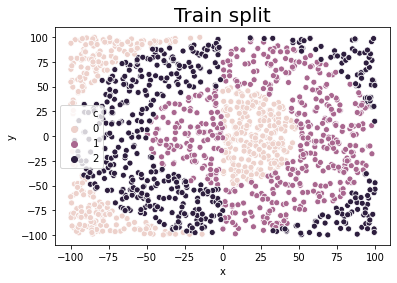

In [153]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
train_df = pd.read_csv('./mio1/classification/rings3-regular-training.csv')
test_df = pd.read_csv('./mio1/classification/rings3-regular-test.csv')
sns.scatterplot(x='x', y='y', hue='c', data=train_df)
plt.title('Train split', fontsize=20)

In [143]:
train_df

,x,y,c
0,-93.563317,-76.345110,0
1,1.060114,-16.727040,0
2,24.396099,40.358822,0
3,-94.595137,-97.889250,0
4,-85.331382,-56.736933,0
...,...,...,...
1495,-3.227585,-69.846357,2
1496,-82.598085,-51.758017,2
1497,-46.601078,-21.654871,2
1498,-59.106450,-44.528442,2


In [145]:
import numpy as np
class EasyEvaluator(Evaluator):
    
    def getDefaultGenome(self):
        genome = Genome()
        node1 = NodeGene(NodeType.INPUT, self.nodeInnovation.getInnovation(), 0, relu)
        node2 = NodeGene(NodeType.INPUT, self.nodeInnovation.getInnovation(), 0, relu)
        node3 = NodeGene(NodeType.OUTPUT, self.nodeInnovation.getInnovation(), 0.5, relu)
        node4 = NodeGene(NodeType.OUTPUT, self.nodeInnovation.getInnovation(), 0.5, relu)
        node5 = NodeGene(NodeType.OUTPUT, self.nodeInnovation.getInnovation(), 0.5, relu)
        genome.addNodeGene(node1)
        genome.addNodeGene(node2)
        genome.addNodeGene(node3)
        genome.addNodeGene(node4)
        genome.addNodeGene(node5)
        
        conn1 = ConnectionGene(node1.id, node3.id, weight=0.0, innovation=self.connectionInnovation.getInnovation())
        conn2 = ConnectionGene(node2.id, node3.id, weight=0.0, innovation=self.connectionInnovation.getInnovation())
        conn3 = ConnectionGene(node1.id, node4.id, weight=0.0, innovation=self.connectionInnovation.getInnovation())
        conn4 = ConnectionGene(node2.id, node4.id, weight=0.0, innovation=self.connectionInnovation.getInnovation())
        conn5 = ConnectionGene(node1.id, node5.id, weight=0.0, innovation=self.connectionInnovation.getInnovation())
        conn6 = ConnectionGene(node2.id, node5.id, weight=0.0, innovation=self.connectionInnovation.getInnovation())
        genome.addConnectionGene(conn1)
        genome.addConnectionGene(conn2)
        genome.addConnectionGene(conn3)
        genome.addConnectionGene(conn4)
        genome.addConnectionGene(conn5)
        genome.addConnectionGene(conn6)
        return genome
    
    def evaluateGenome(self, genome: Genome):
        acc = 0
        for i, row in enumerate(self.inputs):
            c = np.argmax(genome.forward(row))
            if c == self.outputs[i]:
                acc += 1
        return acc / len(inputs)
            
    
    def setData(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs
        
    def learn(self, inputs, outputs, iter_=50):
        self.scores = []
        self.setData(inputs, outputs)
        for i in range(iter_):
            self.evaluate()
            self.scores.append(self.evaluateGenome(self.fittestGenome))
        

In [146]:
connInn = Counter()
nodeInn = Counter()
evaluator = EasyEvaluator(100, nodeInn, connInn)

In [147]:
inputs = train_df[["x", "y"]].to_numpy()
outputs = train_df["c"].to_numpy()

In [148]:
# evaluator.setData(inputs, outputs)
evaluator.learn(inputs, outputs)

/home/anna/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
/home/anna/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [149]:
genome = evaluator.fittestGenome

In [150]:
evaluator.evaluateGenome(genome)

0.5613333333333334

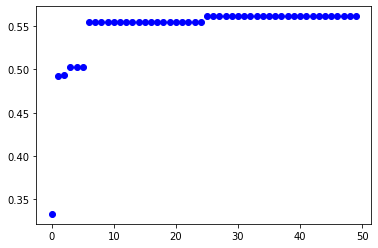

In [151]:
plt.scatter(range(len(evaluator.scores)), evaluator.scores, color='blue')

In [154]:
evaluator.setData(test_df[["x", "y"]].to_numpy(), test_df["c"].to_numpy())
print("Accuracy na zbiorze testowym: ", evaluator.evaluateGenome(genome))

Accuracy na zbiorze testowym:  0.8286666666666667


Tym razem nie udało się uzyskać tak dobrego wyniku jak na zbiorze easy, ale dalej to lepiej niż losowo (do tego zaskakujący jest wynik na zbiorze testowym) i lepiej niż wyszło u mnie na laboratorium z sieci neuronowych.